# Lesson 4b: Hypothesis testing and CLs
some really good slides: https://indico.cern.ch/event/637941/contributions/2606105/attachments/1510179/2358420/limits_statistics_201708_sonneveld.pdf

Further reading: https://arxiv.org/pdf/hep-ex/9902006.pdf, https://arxiv.org/pdf/1007.1727.pdf

Some definitions:

CL = *confidence level*. A probability associated to a *confidence interval*.

note that this has a slightly different meaning for Baysean (P\[theory\]) vs. Frequentist (P\[observation\]) schools of thought.


a CL can be double-sided (usually quoted at 68% CL):

\begin{align}
\mu \pm \sigma ~~[\mbox{at 68\% CL} ~~  = ~~...........|\leftarrow \mu \rightarrow|........
\end{align}

or single-sided (usually quoted at 95% CL, sometimes 90% CL):

\begin{align}
\theta \leq \theta_{\mbox{max}} ~~ [\mbox{at 95% CL}] ~~=~~ ------&\rightarrow|........ \\
&\theta_{\mbox{max}}
\end{align}

CLs is a **modified frequentist method**.

The frequentist limit would be:

\begin{align}
1 - \mbox{CL} \geq \alpha = \mbox{CL}_{s+b} = P(N \geq N_{\mbox{obs}}; \mu = s+b)
\end{align}

but with CLs, we *normalize* this to a background probability. 

\begin{align}
 \mbox{CL}_{s} = \frac{ \mbox{CL}_{s+b}}{ \mbox{CL}_{b}}
\end{align}

Since CL$_{b} \leq 1$, this means that $\mbox{CL}_{s} \geq  \mbox{CL}_{s+b}$. The implications on an experiment are thus that you need a **larger** signal to make an exclusion. This definition is a **conservative** limit. 

Without this normalization, a downward fluctuation in observed events could result in an exclusion, even though the analysis is not sensitive. [Homework: prove this!]

Note that zero signal is never excluded, because $\mbox{CL}_{s=0} =  \mbox{CL}_{s=0+b}/\mbox{CL}_{b} = \mbox{CL}_{b}/\mbox{CL}_{b} =1$.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson,norm,chi2
from scipy import stats
from iminuit import Minuit

Welcome to JupyROOT 6.18/00


In [2]:
%matplotlib notebook

How do we calculate $\mbox{CL}_{b}$, for example? Recall:

\begin{align}
p-\mbox{value} = \sum_{n = n_{obs}}^{\infty} f(n; b),
\end{align}

where $f(n;b)$ is for the background-only hypothesis, and is given by the poisson distribution.  The significance $z$ of a given $p$-value, in terms of $\sigma$, is calculated with:

\begin{align}
\int_{z-\mbox{value}}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2/2} dx = p-\mbox{value},
\end{align}

where this is a **single-sided** significance, so suitable for experiments where we are interested in a deviation in only one direction.

The **expected significance** is the significance associaed with the median number of expected events under the signal + background (s+b) hypothesis.

For example (example from 11.2 in *Data Analysis in High Energy Physics*), say we expect in some experiment, in our signal region, 14.71 background evens and 7.84 signal events. 

*nb: for this discussion, the "number of events" is our test statistic - this is a simple, one bin counting experiment.*

Construct poisson distributions with means of b and s+b:

In [3]:
print poisson.cdf(21,22.55),poisson.sf(21,22.55)
print poisson.cdf(22,22.55),poisson.sf(22,22.55)

0.42571504686015293 0.5742849531398471
0.5098772038268432 0.49012279617315674


<IPython.core.display.Javascript object>


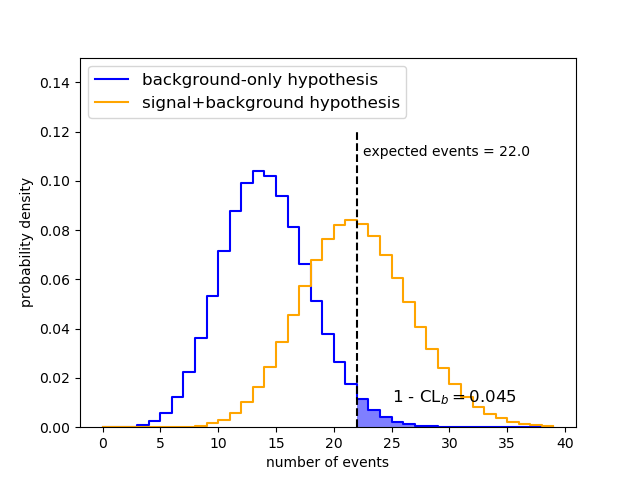

In [4]:
plt.close('all')
x_axis = np.arange(0,40, 1)
y1 = poisson.pmf(x_axis,14.71)
y2 = poisson.pmf(x_axis,14.71+7.84)
plt.step(x_axis, y1, color='blue',label="background-only hypothesis")
plt.step(x_axis, y2, color='orange',label="signal+background hypothesis")
ymin = np.zeros(len(y1))

expected_events = poisson.median(14.71+7.84)
#the book uses 22.55, which is non-integer - and I think rounds this up to 23. But 
#the actual median of he distribution is 22, so we'll use that!

ax = plt.gca()
ax.fill_between(x_axis, ymin, y1, where=x_axis >=expected_events, step='pre' ,facecolor='blue', alpha=0.5)
ax.set_ylim(bottom=0,top=0.15)
ax.set_xlabel("number of events")
ax.set_ylabel("probability density")


#let's call it clbx, because it's 1-CLb, not CLb itself!
clbx = poisson.sf(expected_events,14.71) + poisson.pmf(expected_events,14.71)
#survival function counts ABOVE expected events, not inclusively, so need to add that on.

ax.axvline(expected_events,0,0.8,color='black',linestyle='--')

plt.text(expected_events + 0.5, 0.11, 'expected events = '+str(expected_events), fontsize=10)
plt.text(expected_events + 3, 0.01, r'1 - CL$_b = $'+'{:.3f}'.format(clbx), fontsize=12)

plt.legend(fontsize=12,loc='upper left')

plt.show()

Notice that this is essentially the same figure as our last lesson, where we learned about the size and power of a test. We said, then:

If the observation falls *above* the critical value, we say we can reject the null hypothesis. This then comes along with a probability of being *wrong*, a type-I error, equal to $\alpha$.

We can translate that to "CLs" language:

If the observation falls *above* the critical value, we say we can reject the background-only hypothesis. This then comes along with a probability of being *wrong*, a type-I error, equal to CL$_b$.

Moreover, we can calculate the expected significance of our toy experiment:

In [9]:
#inverse survival function for a gaussian with mean 0 and width 1 (so in units of sigma)
#for a CLb value of our above experiment
norm.isf(clbx,0,1)

1.6960349987942769

so we're looking at a $1.70\sigma$ deviation ($1.92\sigma$ in the text!).

Keep in mind that although our "$p$-value" is less than 0.05, this is not a greater than $2\sigma$ excess. 

Why? 

Our expeced **confidence level** is the confidence level associated with the median expected test statistic value (e.g. number of events) under each hypothesis. If instead we use the observed number of events (rather than $N_{s+b}^{\mbox{exp.}}$),

1 - CLb, as we already calculated, is the probability the significance of the median s+b experiment, for the median expected events under s+b.

We can also calculate the expected confidence level of the s+b hypothesis under background-only hypothesis, by using the median expected background-only events. This tells us the fraction of s+b experiments that would produce $N_{b}^{\mbox{exp.}}$ or fewer events.

And finally, we can calculate the expected CL$_{s}$ value, for the background-only hypothesis.

Noe that things get a little weird here, because our counting experiment makes our test statistic *discrete*. When this is a continuous value, there is less ambiguity about summing and limits.

In [10]:
clbx_bonly = 0.5 #here, we know we have the median = middle, by definition.
median_bonly = poisson.median(14.71)
clsb_bonly = poisson.cdf(median_bonly,14.71+7.84)
print 'expected background-only parameters'
print '1 - CLb: ',clbx_bonly
print 'CLs+b:' , clsb_bonly
print 'CLs = CLs+b / CLb: ' ,clsb_bonly/(1-clbx_bonly)

expected background-only parameters
1 - CLb:  0.5
CLs+b: 0.062180769327111376
CLs = CLs+b / CLb:  0.12436153865422275


What this tells us is that, in the absence of signal, a typical result of our experiment is not very compatible with the s+b hypothesis. However, CLs > 0.05, which tells us that we cannot expect to exclude our signal in this counting experiment, for a signal strength of 1 (at 95% CL!)

Now we imgaine we have observed 25 events. What next...? Do we have a discovery? Or can we exclude our signal? And if we exclude it, what cross-section can we exclude at?

First, let's calculate the $p$-value (i.e. observed 1 - CL$_{b}$):

In [11]:
observed_events = 25
clbx_observed = poisson.sf(observed_events,14.71)+poisson.pmf(observed_events,14.71)
observed_significance = norm.isf(clbx_observed,0,1)
print 'observed 1 - CLb: ',clbx_observed,', which has a significance of: ',observed_significance,'sigma'

observed 1 - CLb:  0.00895879536633783 , which has a significance of:  2.3673167491227587 sigma


Not tiny, but certainly not a discovery. In this case, we want to set an exclusion limit. 

However, there's a catch, because if we calculate CLs, we again see that we can't make a 95% exclusion limit:

In [12]:
clsb_observed = poisson.cdf(25,14.71+7.84)
print 'expected background-only parameters'
print '1 - CLb: ',clbx_observed
print 'CLs+b:' , clsb_observed
print 'CLs = CLs+b / CLb: ' ,clsb_observed/(1 - clbx_observed)

expected background-only parameters
1 - CLb:  0.00895879536633783
CLs+b: 0.7398551393493652
CLs = CLs+b / CLb:  0.7465432677169586


Ok, so we observed nothing and excluded nothing - but that's not necessarily unusual. 

discuss: https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/TOPQ-2012-09/fig_06.png

Our 7.84 expected signal events assumed some production cross-section, let's call it $\sigma_{\mbox{nom.}}$ (nom for nominal). What we can do is artificially increase this $\sigma$ to find what cross-section we *can* exclude. Let's run our expierment, calculating CLs for both the expected and observed scenarios, for different production cross-sections.

In [13]:
def get_cls(ns, nb, ntest):
    t_clbx = poisson.sf(ntest,nb)+poisson.pmf(ntest,nb)
    t_clsb = poisson.cdf(ntest,nb+ns)
    t_cls =  t_clsb / (1-t_clbx) 
    return t_cls
def get_cls_bonly(ns,nb, ntest):
    t_clbx = 0.5
    t_clsb = poisson.cdf(ntest,nb+ns)
    return t_clsb / (1-t_clbx)

<IPython.core.display.Javascript object>


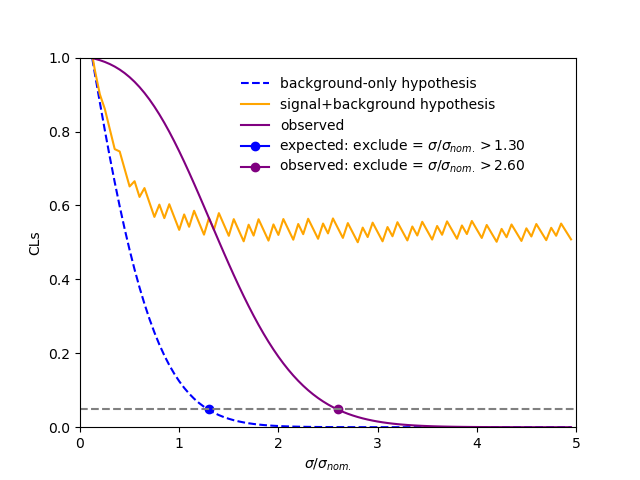

In [83]:
plt.close('all')

#we'll test sigma/sigma_nom between 0 and 5...
xs_over_xsnom = np.arange(0.05,5, 0.05)

cls_vec_obs = []
cls_vec_sb = []
cls_vec_exp = []

exp_005 = [0,999]
obs_005 = [0,999]
for xsval in xs_over_xsnom:
    clsobs = get_cls(xsval*7.84,14.71,25)
    cls_vec_obs += [clsobs]
    cls_vec_sb += [get_cls(xsval*7.84,14.71,poisson.median(xsval*7.84+14.71))]
    clsexp = get_cls_bonly(xsval*7.84,14.71,15)
    cls_vec_exp += [clsexp]
    if abs(clsexp - 0.05) < exp_005[1]:
        exp_005[1] = abs(clsexp - 0.05)
        exp_005[0] = xsval
    if abs(clsobs - 0.05) < obs_005[1]:
        obs_005[1] = abs(clsobs - 0.05)
        obs_005[0] = xsval

exp_str = "{:.2f}".format(exp_005[0])
obs_str = "{:.2f}".format(obs_005[0])

plt.plot(xs_over_xsnom, cls_vec_exp, color='blue',label="background-only hypothesis",linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_sb, color='orange',label="signal+background hypothesis")
plt.plot(xs_over_xsnom, cls_vec_obs, color='purple',label="observed")
plt.plot([exp_005[0]],[0.05],color='blue',marker='o',label = " ")
plt.plot([obs_005[0]],[0.05],color='purple',marker='o',label = " ")

ax = plt.gca()
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=5)
ax.set_xlabel(r'$\sigma$/$\sigma_{nom.}$')
ax.set_ylabel("CLs")

ax.axhline(0.05,0,5,color='grey',linestyle='--')

plt.text(2.01, 0.75, 'expected: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+exp_str,fontsize=10,color='black')
plt.text(2.01, 0.695, 'observed: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+obs_str,fontsize=10,color='black')


plt.legend(fontsize=10,loc='bottom left',frameon=False,bbox_to_anchor=(0.3,0.65))

plt.show()

The jaggedness in s+b hypothesis comes from the discrete nature of the median from the poisson distribution - normally you would not see this with CLs, because you would have a slightly more complex model - it just shows up in my simplified toy experiment.

We now have both our expected and our observed limits. But what about the error bands on the expected limits?

These are determined by fluctuating the estimated background by $1\sigma$ (containing 68% of possible background values, from the poisson) and $2\sigma$ (containing 95%).

<IPython.core.display.Javascript object>


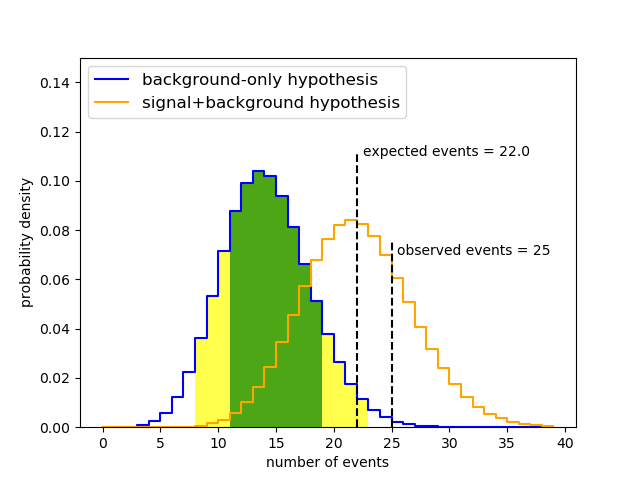

median b-only:  15.0
    +/- 1 sigma:  11.0 19.0
    +/- 2 sigma:  8.0 23.0


In [84]:
plt.close('all')
x_axis = np.arange(0,40, 1)
y1 = poisson.pmf(x_axis,14.71)
y2 = poisson.pmf(x_axis,14.71+7.84)
plt.step(x_axis, y1, color='blue',label="background-only hypothesis")
plt.step(x_axis, y2, color='orange',label="signal+background hypothesis")
ymin = np.zeros(len(y1))

expected_events = poisson.median(14.71+7.84)
observed_events = 25
#the book uses 22.55, which is non-integer - and I think rounds this up to 23. But 
#the actual median of he distribution is 22, so we'll use that!

ax = plt.gca()


ax.fill_between(x_axis, ymin, y1, where=abs(x_axis - 15.5)<=7.5, step='pre' ,facecolor='yellow', alpha=0.7)
ax.fill_between(x_axis, ymin, y1, where=abs(x_axis - 15)<=4, step='pre' ,facecolor='green', alpha=0.7)

ax.set_ylim(bottom=0,top=0.15)
ax.set_xlabel("number of events")
ax.set_ylabel("probability density")

#let's call it clbx, because it's 1-CLb, not CLb itself!
clbx = poisson.sf(expected_events,14.71) + poisson.pmf(expected_events,14.71)
#survival function counts ABOVE expected events, not inclusively, so need to add that on.

ax.axvline(expected_events,0,0.74,color='black',linestyle='--')
ax.axvline(observed_events,0,0.5,color='black',linestyle='--')

plt.text(expected_events + 0.5, 0.11, 'expected events = '+str(expected_events), fontsize=10)
plt.text(observed_events + 0.5, 0.07, 'observed events = '+str(observed_events), fontsize=10)


plt.legend(fontsize=12,loc='upper left')

#calculate 1 and 2 sigmal bands CENTRED on the median background expectation
(min_2s,max_2s) = poisson.interval(0.954,14.71)
(min_1s,max_1s) = poisson.interval(0.683,14.71)

print 'median b-only: ',poisson.median(14.71)
print '    +/- 1 sigma: ',min_1s,max_1s
print '    +/- 2 sigma: ',min_2s,max_2s
plt.show()

Now we have the values of 1/2 sigma on the background estimation to calculate the uncertainties on our expected limit:

<IPython.core.display.Javascript object>


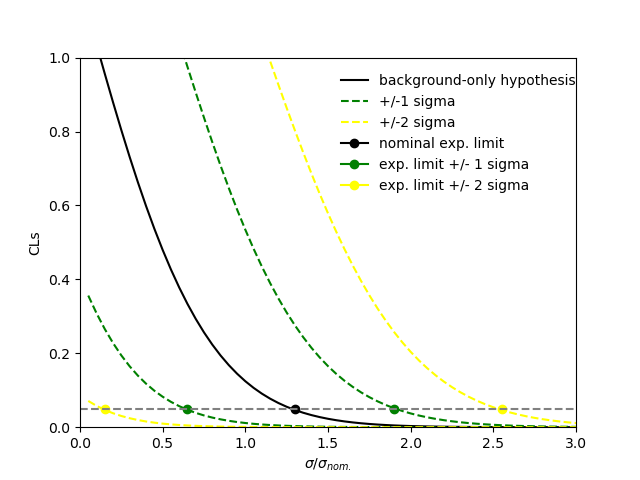

In [100]:
def get_vecs(xs_over_xsnom,expb):
    exp_tmp = [0,999]
    vec_exp= []
    for xsval in xs_over_xsnom:
        t_clsexp = get_cls_bonly(xsval*7.84,14.71,expb)
        vec_exp += [t_clsexp]
        if abs(t_clsexp - 0.05) < exp_tmp[1]:
            exp_tmp[1] = abs(t_clsexp - 0.05)
            exp_tmp[0] = xsval
    return vec_exp,exp_tmp[0]
        
plt.close('all')

#we'll test sigma/sigma_nom between 0 and 5...
xs_over_xsnom = np.arange(0.05,5, 0.05)

cls_vec_exp, exp_lim_nominal = get_vecs(xs_over_xsnom,15)

cls_vec_exp_1u, exp_lim_1u = get_vecs(xs_over_xsnom,19)
cls_vec_exp_1d, exp_lim_1d = get_vecs(xs_over_xsnom,11)
cls_vec_exp_2u, exp_lim_2u = get_vecs(xs_over_xsnom,23)
cls_vec_exp_2d, exp_lim_2d = get_vecs(xs_over_xsnom,8)

plt.plot(xs_over_xsnom, cls_vec_exp, color='black',label="background-only hypothesis")

plt.plot(xs_over_xsnom, cls_vec_exp_1u, color='green',label="+/-1 sigma",linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_exp_1d, color='green',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_exp_2u, color='yellow',label="+/-2 sigma",linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_exp_2d, color='yellow',linestyle = '--')

plt.plot([exp_lim_nominal],[0.05],color='black',marker='o',label = "nominal exp. limit")
plt.plot([exp_lim_1u],[0.05],color='green',marker='o',label = "exp. limit +/- 1 sigma")
plt.plot([exp_lim_1d],[0.05],color='green',marker='o')
plt.plot([exp_lim_2u],[0.05],color='yellow',marker='o',label = "exp. limit +/- 2 sigma")
plt.plot([exp_lim_2d],[0.05],color='yellow',marker='o')


ax = plt.gca()
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=3)
ax.set_xlabel(r'$\sigma$/$\sigma_{nom.}$')
ax.set_ylabel("CLs")

ax.axhline(0.05,0,5,color='grey',linestyle='--')

plt.legend(fontsize=10,loc='bottom left',frameon=False,bbox_to_anchor=(0.5,0.6))

plt.show()

And finally, to wrap this up, we'll make the plot a little more recognizable:

<IPython.core.display.Javascript object>


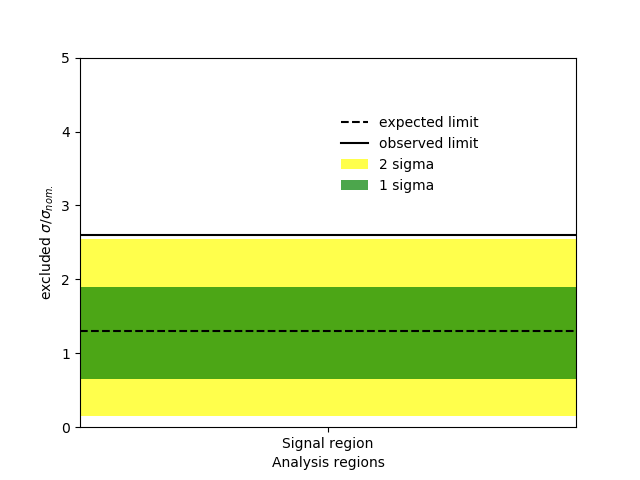

In [128]:
plt.close('all')

ax = plt.gca()

ax.fill_between([0,1], exp_lim_2d, exp_lim_2u,  step='pre' ,facecolor='yellow', alpha=0.7,label='2 sigma')
ax.fill_between([0,1], exp_lim_1d, exp_lim_1u,  step='pre' ,facecolor='green', alpha=0.7,label ='1 sigma')

plt.plot([0,1],[exp_lim_nominal,exp_lim_nominal],color='black',linestyle = '--',label = "expected limit")
plt.plot([0,1],[obs_005[0],obs_005[0]],color='black',label = "observed limit")


ax.set_ylim(bottom=0,top=5)
ax.set_xlim(left=0,right=1)
ax.set_ylabel(r'excluded $\sigma$/$\sigma_{nom.}$')
ax.set_xlabel("Analysis regions")
ax.set_xticks([0.5])
ax.set_xticklabels(["Signal region"])

plt.legend(fontsize=10,loc='bottom left',frameon=False,bbox_to_anchor=(0.5,0.6))

plt.show()

## Next time:

We're going to expand our toy experiment to a slightly less trivial case, where we'll include a profile likelihood scenario instead of just a counting experiment.